# Task-Based Merge Rate Analysis

This notebook analyzes merge rates per task type for all agents in the AIDEV-Pop dataset.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

## 2. Load Merged Data for All Agents

In [2]:
# Load merged PR tables (and optional resolution-augmented tables) for every agent
dataset_root = Path("AIDev/aidev-pop").resolve()
merged_filename = "merged_prs_commits.csv"
resolution_filename = "merged_prs_commits_with_resolution.csv"

if not dataset_root.exists():
    raise FileNotFoundError(
        "Expected the AIDEV-Pop dataset under 'AIDev/aidev-pop'. "
        "Update dataset_root if you have a different layout."
    )

agent_dirs = tuple(sorted(p for p in dataset_root.iterdir() if p.is_dir()))
if not agent_dirs:
    raise RuntimeError(f'No agent subdirectories found under {dataset_root}.')

merged_data = {}
resolution_data = {}
missing = {'merged': [], 'resolution': []}

for agent_dir in agent_dirs:
    agent = agent_dir.name
    merged_path = agent_dir / merged_filename
    if merged_path.exists():
        merged_data[agent] = pd.read_csv(merged_path)
    else:
        missing['merged'].append(agent)

    resolution_path = agent_dir / resolution_filename
    if resolution_path.exists():
        resolution_data[agent] = pd.read_csv(resolution_path)
    else:
        missing['resolution'].append(agent)

for category, absent_agents in missing.items():
    if absent_agents:
        print(f"[WARN] Missing {category} file for: {', '.join(sorted(absent_agents))}")

if not merged_data:
    raise RuntimeError('No merged PR files were loaded. Verify the dataset layout and filenames.')

agents = sorted(merged_data.keys())
print(f"[INFO] Loaded merged data for {len(agents)} agents.")

[INFO] Loaded merged data for 5 agents.


### Get count of merged data...

In [3]:
count = 0
for agent, data in merged_data.items():
    count += len(data)
    
print(count)

33600


## 3. Extract All Unique Task Types

## 4. Compute Merge Rates Per Task Type

In [4]:
def compute_merge_rate_per_task(df: pd.DataFrame, task_col: str) -> pd.DataFrame:
    """Return merged/closed counts and merge rates by task."""
    closed_prs = df[df['closed_at'].notna()].copy()
    if closed_prs.empty:
        return pd.DataFrame(columns=['task_type', 'closed_count', 'merged_count', 'merge_rate'])

    aggregated = (
        closed_prs.assign(is_merged=closed_prs['merged_at'].notna())
        .groupby(task_col)
        .agg(
            closed_count=('is_merged', 'size'),
            merged_count=('is_merged', 'sum')
        )
        .assign(
            merge_rate=lambda frame: frame['merged_count'] / frame['closed_count']
        )
        .reset_index()
        .rename(columns={task_col: 'task_type'})
    )
    return aggregated

def choose_task_column(columns):
    lowered = {col: col.lower() for col in columns}
    preference_order = (
        "task_type",
        "pr_task_type",
        "pull_request_task",
        "task",
        "category",
        "type"
    )
    for preference in preference_order:
        for col, lowered_name in lowered.items():
            if preference in lowered_name:
                return col
    return None

task_column_by_agent = {}
for agent, df in merged_data.items():
    inferred = choose_task_column(df.columns)
    if inferred is None:
        print(f"[WARN] {agent}: unable to infer task-type column; skipping merge-rate computation.")
        continue
    task_column_by_agent[agent] = inferred

agent_task_merge_rates = {}
merge_support_records = []

for agent, df in merged_data.items():
    task_col = task_column_by_agent.get(agent)
    if task_col is None:
        continue
    stats = compute_merge_rate_per_task(df, task_col)
    if stats.empty:
        print(f"[WARN] {agent}: no closed pull requests available for merge-rate computation.")
        continue
    agent_task_merge_rates[agent] = stats.set_index('task_type').to_dict('index')
    stats = stats.assign(agent=agent)
    merge_support_records.append(stats)

if not merge_support_records:
    raise RuntimeError('No merge-rate statistics could be computed; verify task column inference.')

merge_support_df = pd.concat(merge_support_records, ignore_index=True)
print('[INFO] Merge-rate statistics computed for each agent/task combination.')
display(merge_support_df)

[INFO] Merge-rate statistics computed for each agent/task combination.


,task_type,closed_count,merged_count,merge_rate,agent
0,build,7,7,1.000000,Claude_Code
1,chore,12,10,0.833333,Claude_Code
2,ci,5,4,0.800000,Claude_Code
3,docs,32,24,0.750000,Claude_Code
4,feat,202,142,0.702970,Claude_Code
5,fix,91,66,0.725275,Claude_Code
6,perf,3,2,0.666667,Claude_Code
7,refactor,23,13,0.565217,Claude_Code
8,test,5,3,0.600000,Claude_Code
9,build,109,60,0.550459,Copilot


In [5]:
# Display merge rates for a sample agent (Devin)
if 'Devin' in agent_task_merge_rates:
    print("Sample: Devin merge rates per task type")
    print("="*60)
    for task_type, rates in sorted(agent_task_merge_rates['Devin'].items()):
        print(f"{task_type:30s}: {rates['merge_rate']:.3f} ({rates['merged_count']}/{rates['closed_count']})")

Sample: Devin merge rates per task type
build                         : 0.587 (37/63)
chore                         : 0.570 (159/279)
ci                            : 0.610 (36/59)
docs                          : 0.727 (442/608)
feat                          : 0.567 (1035/1827)
fix                           : 0.443 (536/1211)
other                         : 0.000 (0/3)
perf                          : 0.361 (22/61)
refactor                      : 0.590 (248/420)
revert                        : 0.667 (4/6)
style                         : 0.680 (17/25)
test                          : 0.532 (59/111)


## 5. Visualize Merge Rates Per Task Type for Each Agent

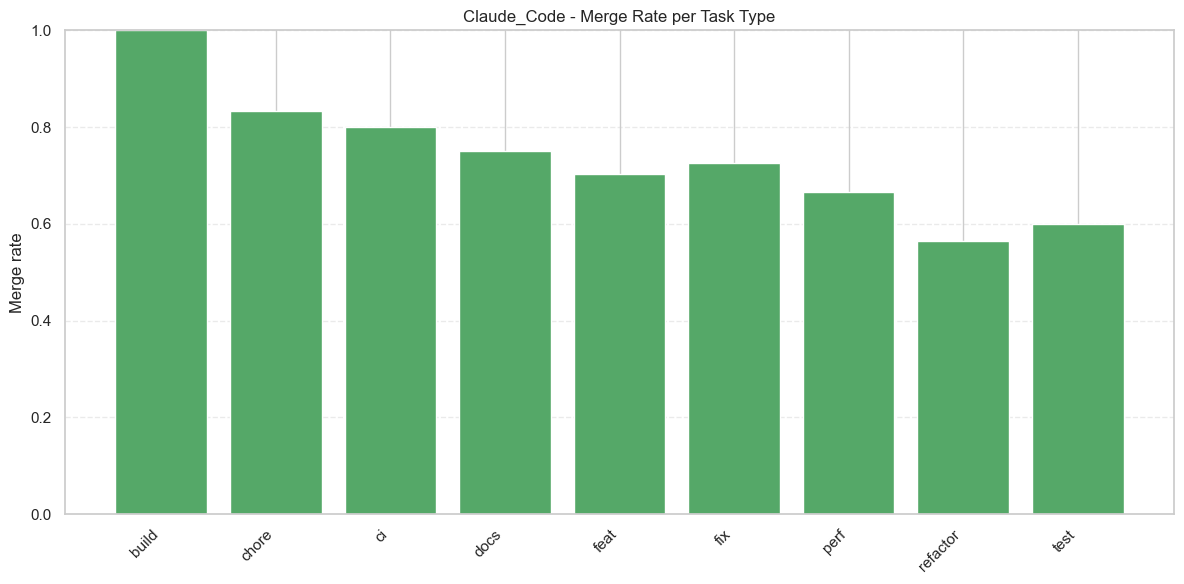


Claude_Code - Task type merge rates:
  build                         : 1.000 (7/7)
  chore                         : 0.833 (10/12)
  ci                            : 0.800 (4/5)
  docs                          : 0.750 (24/32)
  feat                          : 0.703 (142/202)
  fix                           : 0.725 (66/91)
  perf                          : 0.667 (2/3)
  refactor                      : 0.565 (13/23)
  test                          : 0.600 (3/5)


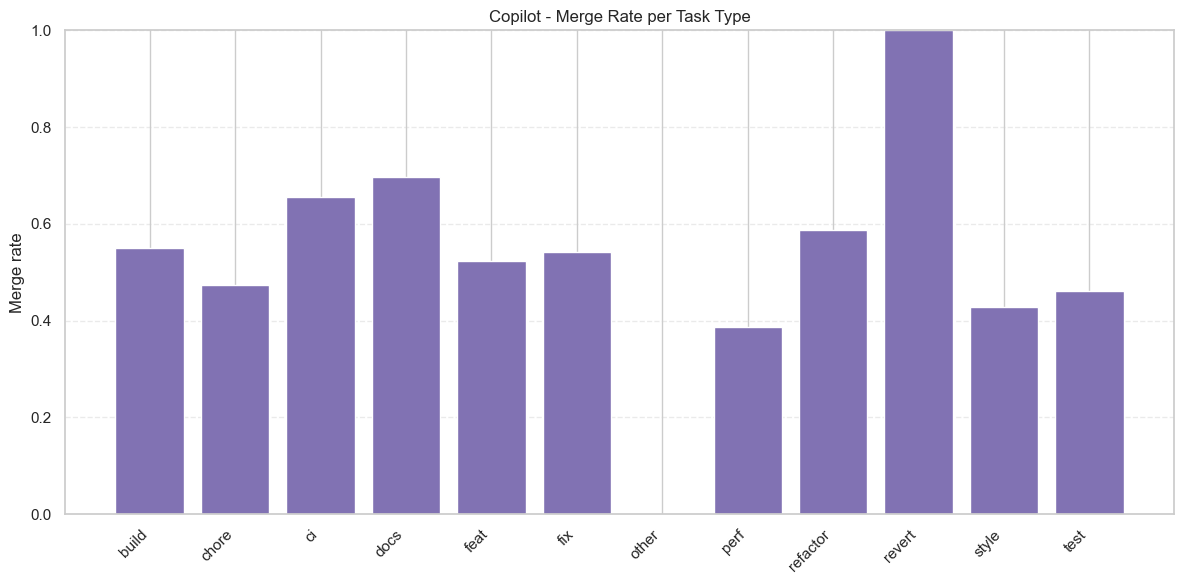


Copilot - Task type merge rates:
  build                         : 0.550 (60/109)
  chore                         : 0.474 (55/116)
  ci                            : 0.656 (42/64)
  docs                          : 0.697 (278/399)
  feat                          : 0.523 (632/1208)
  fix                           : 0.542 (845/1558)
  other                         : 0.000 (0/11)
  perf                          : 0.387 (12/31)
  refactor                      : 0.588 (144/245)
  revert                        : 1.000 (4/4)
  style                         : 0.429 (6/14)
  test                          : 0.462 (61/132)


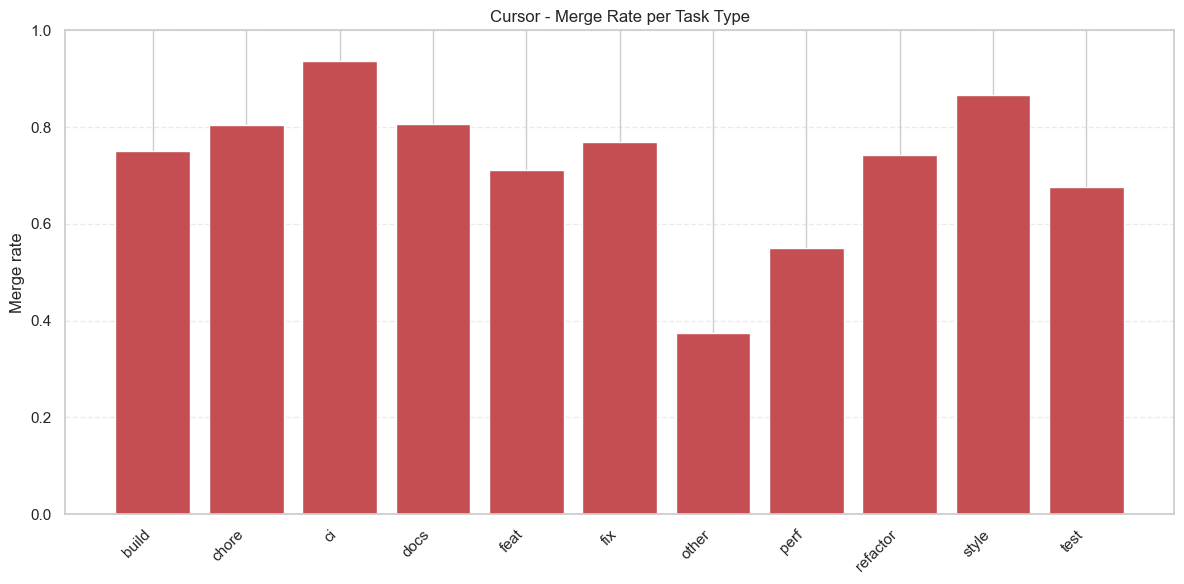


Cursor - Task type merge rates:
  build                         : 0.750 (24/32)
  chore                         : 0.804 (37/46)
  ci                            : 0.938 (15/16)
  docs                          : 0.806 (154/191)
  feat                          : 0.711 (372/523)
  fix                           : 0.770 (281/365)
  other                         : 0.375 (3/8)
  perf                          : 0.550 (11/20)
  refactor                      : 0.742 (72/97)
  style                         : 0.867 (13/15)
  test                          : 0.676 (23/34)


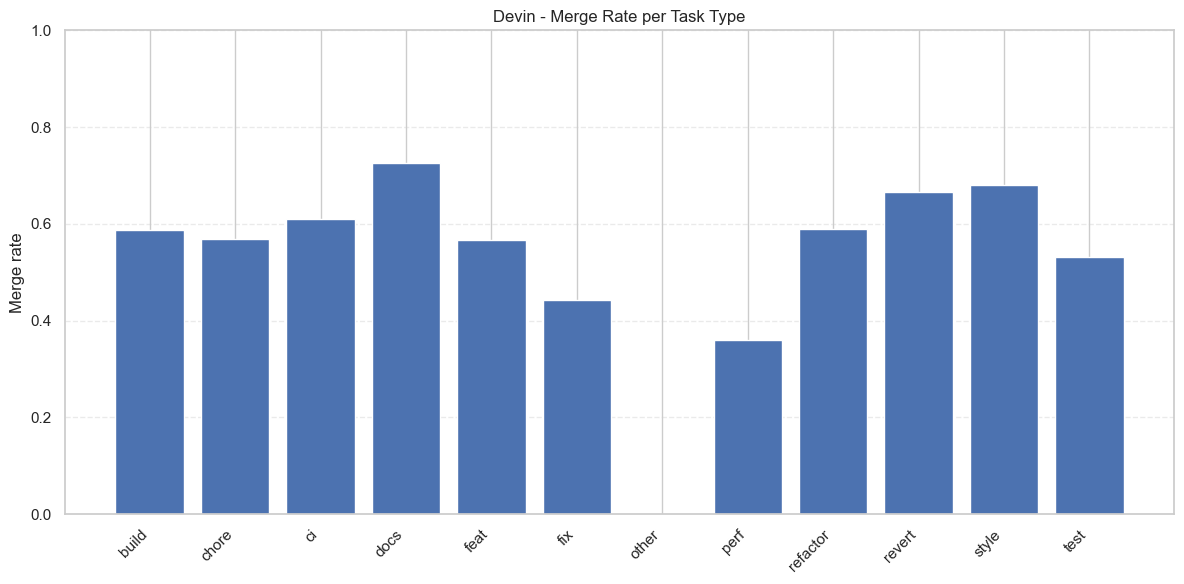


Devin - Task type merge rates:
  build                         : 0.587 (37/63)
  chore                         : 0.570 (159/279)
  ci                            : 0.610 (36/59)
  docs                          : 0.727 (442/608)
  feat                          : 0.567 (1035/1827)
  fix                           : 0.443 (536/1211)
  other                         : 0.000 (0/3)
  perf                          : 0.361 (22/61)
  refactor                      : 0.590 (248/420)
  revert                        : 0.667 (4/6)
  style                         : 0.680 (17/25)
  test                          : 0.532 (59/111)


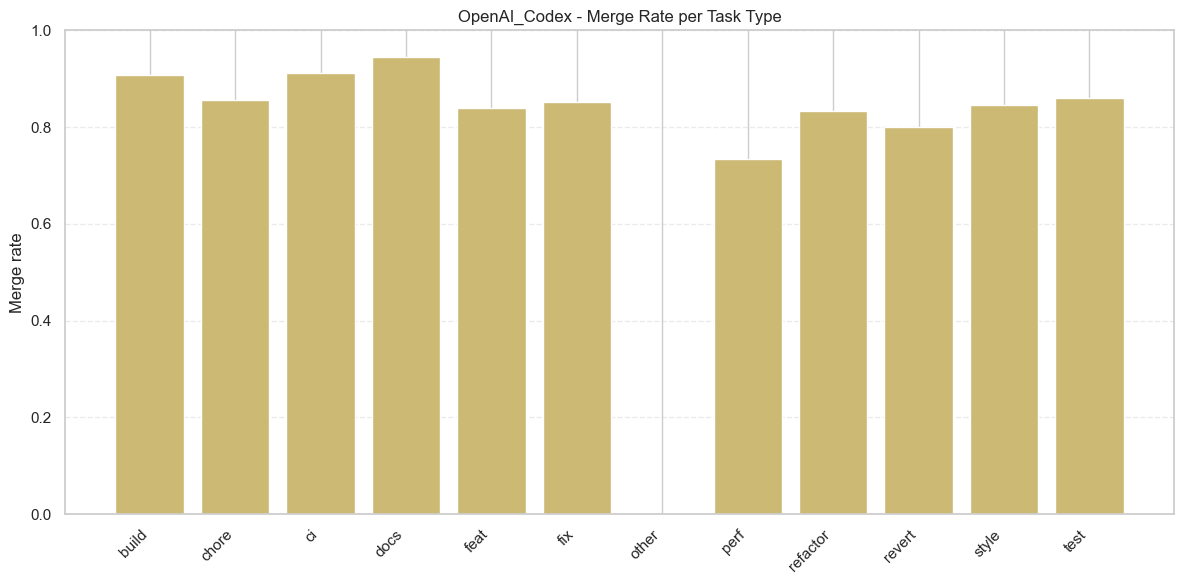


OpenAI_Codex - Task type merge rates:
  build                         : 0.907 (341/376)
  chore                         : 0.855 (355/415)
  ci                            : 0.912 (228/250)
  docs                          : 0.945 (2369/2507)
  feat                          : 0.840 (8089/9626)
  fix                           : 0.852 (3539/4155)
  other                         : 0.000 (0/7)
  perf                          : 0.734 (141/192)
  refactor                      : 0.833 (1127/1353)
  revert                        : 0.800 (4/5)
  style                         : 0.846 (110/130)
  test                          : 0.860 (1701/1977)


In [6]:
# Create bar plots for each agent, following the style from agent_merge_rate_exploration.ipynb
colors = {
    'Devin': '#4C72B0',
    'Claude_Code': '#55A868',
    'Cursor': '#C44E52',
    'Copilot': '#8172B3',
    'OpenAI_Codex': '#CCB974'
}

for agent, task_rates in agent_task_merge_rates.items():
    # Prepare data for plotting
    task_types = list(task_rates.keys())
    merge_rates = [task_rates[task]['merge_rate'] for task in task_types]
    
    # Sort by task type for consistent display
    sorted_data = sorted(zip(task_types, merge_rates))
    task_types_sorted = [x[0] for x in sorted_data]
    merge_rates_sorted = [x[1] for x in sorted_data]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    color = colors.get(agent, '#4C72B0')
    plt.bar(task_types_sorted, merge_rates_sorted, color=color)
    plt.ylabel("Merge rate")
    plt.title(f"{agent} - Merge Rate per Task Type")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{agent} - Task type merge rates:")
    for task, rate in sorted_data:
        counts = task_rates[task]
        print(f"  {task:30s}: {rate:.3f} ({counts['merged_count']}/{counts['closed_count']})")

## 6. Summary: Compare All Agents on Same Task Types

In [7]:
# Create a comparison DataFrame showing all agents' merge rates for each task type
import numpy as np

# Get all unique task types across all agents
all_tasks = set()
for agent_rates in agent_task_merge_rates.values():
    all_tasks.update(agent_rates.keys())

all_tasks = sorted(all_tasks)

# Build comparison matrix
comparison_data = []
for task in all_tasks:
    row = {'task_type': task}
    for agent in agent_task_merge_rates.keys():
        if task in agent_task_merge_rates[agent]:
            row[agent] = agent_task_merge_rates[agent][task]['merge_rate']
        else:
            row[agent] = np.nan
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)
print("Merge Rate Comparison Across All Agents")
print("="*80)
print(comparison_df.to_string(index=False))

# Save to CSV for further analysis
comparison_df.to_csv("task_merge_rate_comparison.csv", index=False)
print("\nSaved comparison to task_merge_rate_comparison.csv")

Merge Rate Comparison Across All Agents
task_type  Claude_Code  Copilot   Cursor    Devin  OpenAI_Codex
    build     1.000000 0.550459 0.750000 0.587302      0.906915
    chore     0.833333 0.474138 0.804348 0.569892      0.855422
       ci     0.800000 0.656250 0.937500 0.610169      0.912000
     docs     0.750000 0.696742 0.806283 0.726974      0.944954
     feat     0.702970 0.523179 0.711281 0.566502      0.840328
      fix     0.725275 0.542362 0.769863 0.442609      0.851745
    other          NaN 0.000000 0.375000 0.000000      0.000000
     perf     0.666667 0.387097 0.550000 0.360656      0.734375
 refactor     0.565217 0.587755 0.742268 0.590476      0.832964
   revert          NaN 1.000000      NaN 0.666667      0.800000
    style          NaN 0.428571 0.866667 0.680000      0.846154
     test     0.600000 0.462121 0.676471 0.531532      0.860395

Saved comparison to task_merge_rate_comparison.csv


Found 12 task types common to at least 3 agents:
['build', 'chore', 'ci', 'docs', 'feat', 'fix', 'other', 'perf', 'refactor', 'revert', 'style', 'test']


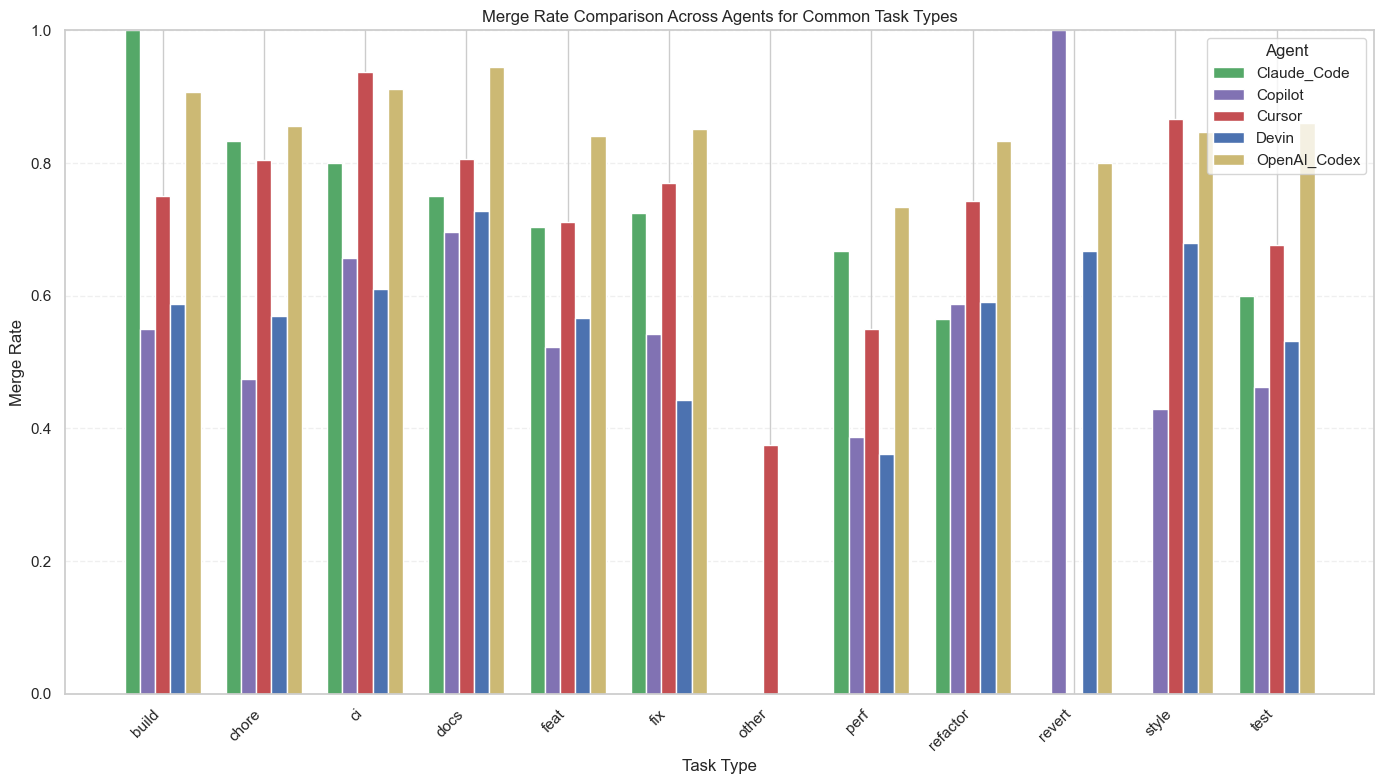

In [8]:
# Visualize comparison: grouped bar chart for selected common task types
common_tasks = []
for task in all_tasks:
    count = sum(1 for agent in agent_task_merge_rates.keys() if task in agent_task_merge_rates[agent])
    if count >= 3:
        common_tasks.append(task)

print(f"Found {len(common_tasks)} task types common to at least 3 agents:")
print(common_tasks)

if common_tasks:
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(common_tasks))
    width = 0.15
    multiplier = 0

    for agent in sorted(agent_task_merge_rates.keys()):
        rates = [agent_task_merge_rates[agent].get(task, {}).get('merge_rate', np.nan) for task in common_tasks]
        offset = width * multiplier
        color = colors.get(agent, '#4C72B0')
        ax.bar(x + offset, rates, width, label=agent, color=color)
        multiplier += 1

    ax.set_ylabel('Merge Rate')
    ax.set_xlabel('Task Type')
    ax.set_title('Merge Rate Comparison Across Agents for Common Task Types')
    ax.set_xticks(x + width * (len(agent_task_merge_rates) - 1) / 2)
    ax.set_xticklabels(common_tasks, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.legend(title='Agent')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('No task types meet the minimum agent coverage for visualization.')

## 8. Mean Resolution Time per Agent and Task Type

[OK] Claude_Code: computed means for 9 task types (samples per task: min=2, max=142)
[OK] Copilot: computed means for 11 task types (samples per task: min=4, max=845)
[OK] Cursor: computed means for 11 task types (samples per task: min=3, max=372)
[OK] Devin: computed means for 11 task types (samples per task: min=4, max=1035)
[OK] OpenAI_Codex: computed means for 11 task types (samples per task: min=4, max=8089)


,agent,task_type,mean_resolution_days,resolution_samples
0,Claude_Code,build,0.044238,7
1,Claude_Code,chore,3.929146,10
2,Claude_Code,ci,0.010677,4
3,Claude_Code,docs,1.419413,24
4,Claude_Code,feat,1.712529,142
5,Claude_Code,fix,2.928581,66
6,Claude_Code,perf,0.237633,2
7,Claude_Code,refactor,1.874452,13
8,Claude_Code,test,0.333295,3
9,Copilot,build,2.980592,60


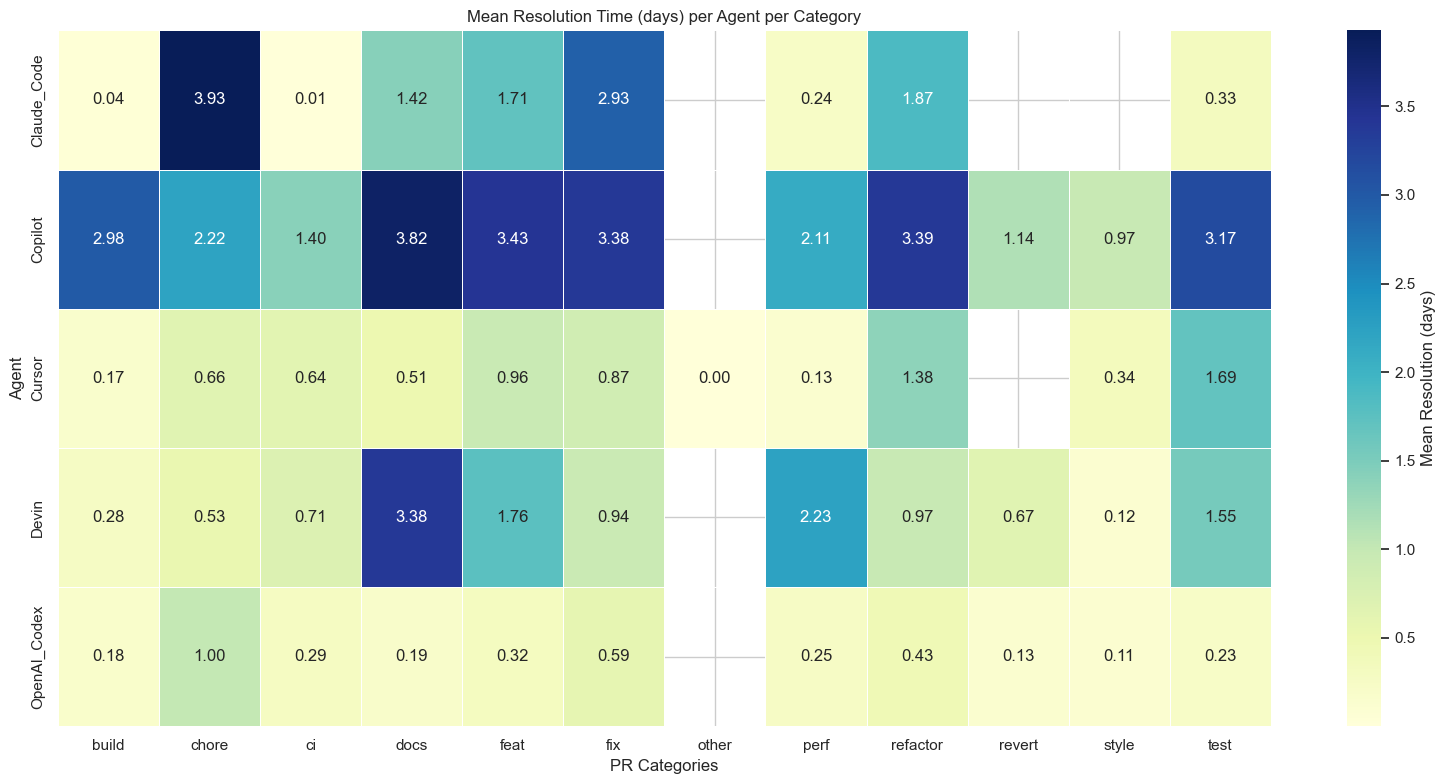

Saved mean resolution heatmap data to task_mean_resolution_by_agent.csv and sample counts to task_resolution_sample_counts_by_agent.csv


In [9]:
agent_task_resolution = {}
resolution_records = []

for agent, df in resolution_data.items():
    task_columns = [col for col in df.columns if "type" in col.lower() or "task" in col.lower()]
    if not task_columns:
        print(f"[WARN] {agent}: no task-type column found, skipping aggregation")
        continue

    task_col = task_columns[0]
    resolved = (
        df[[task_col, "resolution_time_days"]]
        .dropna(subset=[task_col, "resolution_time_days"])
    )

    if resolved.empty:
        print(f"[INFO] {agent}: no resolvable tasks after filtering")
        continue

    aggregated = (
        resolved
        .groupby(task_col)["resolution_time_days"]
        .agg(mean_resolution_days="mean", resolution_samples="count")
        .reset_index()
        .rename(columns={task_col: "task_type"})
    )

    agent_task_resolution[agent] = aggregated

    for _, row in aggregated.iterrows():
        resolution_records.append(
            {
                "agent": agent,
                "task_type": row["task_type"],
                "mean_resolution_days": row["mean_resolution_days"],
                "resolution_samples": int(row["resolution_samples"]),
            }
        )

    min_samples = int(aggregated["resolution_samples"].min())
    max_samples = int(aggregated["resolution_samples"].max())
    print(
        f"[OK] {agent}: computed means for {len(aggregated)} task types "
        f"(samples per task: min={min_samples}, max={max_samples})"
    )

if not resolution_records:
    print("No resolution statistics available to summarize.")
else:
    resolution_summary_df = pd.DataFrame(resolution_records)
    resolution_summary_df = resolution_summary_df.sort_values(["agent", "task_type"])

    pivot_df = (
        resolution_summary_df.pivot(index="agent", columns="task_type", values="mean_resolution_days")
        .sort_index()
        .sort_index(axis=1)
    )

    resolution_counts_pivot = (
        resolution_summary_df.pivot(index="agent", columns="task_type", values="resolution_samples")
        .sort_index()
        .sort_index(axis=1)
    )

    display(resolution_summary_df)

    pivot_output = Path("task_mean_resolution_by_agent.csv")
    pivot_df.to_csv(pivot_output)

    counts_output = Path("task_resolution_sample_counts_by_agent.csv")
    resolution_counts_pivot.to_csv(counts_output)

    plt.figure(figsize=(16, 8))
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        linewidths=0.5,
        cbar_kws={"label": "Mean Resolution (days)"}
    )
    plt.title("Mean Resolution Time (days) per Agent per Category")
    plt.xlabel("PR Categories")
    plt.ylabel("Agent")
    plt.tight_layout()
    plt.show()

    print(
        "Saved mean resolution heatmap data to",
        pivot_output,
        "and sample counts to",
        counts_output,
    )

## 9. RQ1: Correlation Between Efficacy and Efficiency (PR-Level Analysis)

**Research Question 1:** Can coding agents be both efficient and effective across different stages of software development?

**Operational Question:** Does merge rate (effectiveness) correlate with resolution time (efficiency) for individual PRs within each agent-task combination?

**Methodology:**
1. **Unit of Analysis:** Individual PRs within each agent-task type combination
2. **Variables:**
   - Independent: Merge Status
   - Dependent: Resolution Time (days from PR creation to closure/merge)
3. **Statistical Approach:**
   - For each agent-task combination with ≥3 PRs:
     - Calculate Spearman correlation coefficient
     - Categorize effect sizes (negligible, small, moderate, large)
   - Analyze patterns across ~55 agent-task combinations

**Expected Sample Sizes:** Varies from 3 to 8,000+ PRs per agent-task combination

In [10]:

# For each agent, extract PR-level data with merge status and resolution time
rq1_pr_data_by_agent_task = {}

for agent in agents:
    # Get merged data (has closed_at, merged_at columns)
    merged_df = merged_data.get(agent)
    if merged_df is None:
        print(f"[WARN] {agent}: no merged data available, skipping")
        continue
    
    # Get resolution data (has resolution_time_days)
    resolution_df = resolution_data.get(agent)
    if resolution_df is None:
        print(f"[WARN] {agent}: no resolution data available, skipping")
        continue
    
    # Get task column
    task_col = task_column_by_agent.get(agent)
    if task_col is None:
        print(f"[WARN] {agent}: no task column identified, skipping")
        continue
    
    merged_temp = merged_df[merged_df['closed_at'].notna()].copy()
    merged_temp['is_merged'] = merged_temp['merged_at'].notna().astype(int)
    
    if 'number' in merged_temp.columns and 'number' in resolution_df.columns:
        pr_key = 'number'
    elif 'id' in merged_temp.columns and 'id' in resolution_df.columns:
        pr_key = 'id'
    else:
        print(f"[WARN] {agent}: cannot find common PR identifier")
        continue
    
    combined = merged_temp[[pr_key, task_col, 'is_merged', 'closed_at', 'created_at', 'merged_at']].merge(
        resolution_df[[pr_key, 'resolution_time_days']],
        on=pr_key,
        how='left'
    )
    
    for idx, row in combined[combined['resolution_time_days'].isna()].iterrows():
        if pd.notna(row['closed_at']) and pd.notna(row['created_at']):
            closed = pd.to_datetime(row['closed_at'])
            created = pd.to_datetime(row['created_at'])
            combined.at[idx, 'resolution_time_days'] = (closed - created).total_seconds() / 86400
    
    for task_type, group in combined.groupby(task_col):

        valid_group = group.dropna(subset=['resolution_time_days'])
        
        if len(valid_group) < 3:
            continue  
        
        key = (agent, task_type)
        rq1_pr_data_by_agent_task[key] = valid_group[['is_merged', 'resolution_time_days']].copy()
    
    print(f"[OK] {agent}: {len([k for k in rq1_pr_data_by_agent_task.keys() if k[0] == agent])} task types with ≥3 PRs")


[OK] Claude_Code: 9 task types with ≥3 PRs
[OK] Copilot: 12 task types with ≥3 PRs
[OK] Cursor: 11 task types with ≥3 PRs
[OK] Devin: 12 task types with ≥3 PRs
[OK] OpenAI_Codex: 12 task types with ≥3 PRs


In [11]:
for (agent, task_type), data in sorted(rq1_pr_data_by_agent_task.items()):
    print(data)

     is_merged  resolution_time_days
50           1              0.003021
62           1              0.038588
242          1              0.003449
313          1              0.063171
331          1              0.014630
333          1              0.167222
397          1              0.019583
     is_merged  resolution_time_days
5            0              1.492303
52           1              2.865116
70           1              1.828530
119          1              4.837037
190          1              0.000069
191          1              0.005579
321          0              0.025382
322          1              0.001458
327          1              5.240556
347          1              1.244838
354          1             22.995475
361          1              0.255255
363          1              0.023125
     is_merged  resolution_time_days
78           0              0.003391
183          1              0.015590
184          1              0.010648
185          1              0.009097
3

In [12]:
# Correlation Analysis per Agent-Task Combination
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

correlation_results = []

for (agent, task_type), data in sorted(rq1_pr_data_by_agent_task.items()):
    n = len(data)
    n_merged = data['is_merged'].sum()
    n_unmerged = n - n_merged
    
    # Skip if no variance in merge status (all merged or all unmerged)
    if n_merged == 0 or n_unmerged == 0:
        continue
    
    # Calculate Spearman correlation
    corr_coef, _ = spearmanr(data['is_merged'], data['resolution_time_days'])
    
    # Effect size categorization
    abs_corr = abs(corr_coef)
    if abs_corr < 0.1:
        effect_size = "negligible"
    elif abs_corr < 0.3:
        effect_size = "small"
    elif abs_corr < 0.5:
        effect_size = "moderate"
    else:
        effect_size = "large"
    
    # Calculate mean resolution times by merge status
    mean_resolution_merged = data[data['is_merged'] == 1]['resolution_time_days'].mean()
    mean_resolution_unmerged = data[data['is_merged'] == 0]['resolution_time_days'].mean()
    
    correlation_results.append({
        'agent': agent,
        'task_type': task_type,
        'n_prs': n,
        'n_merged': n_merged,
        'n_unmerged': n_unmerged,
        'merge_rate': n_merged / n,
        'mean_resolution_merged': mean_resolution_merged,
        'mean_resolution_unmerged': mean_resolution_unmerged,
        'correlation_coefficient': corr_coef,
        'effect_size_category': effect_size,
        'abs_correlation': abs_corr
    })

# Create results DataFrame
rq1_correlation_df = pd.DataFrame(correlation_results)

print(f"Analyzed {len(rq1_correlation_df)} agent-task combinations\n")
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Total combinations analyzed: {len(rq1_correlation_df)}")
print(f"Positive correlations: {(rq1_correlation_df['correlation_coefficient'] > 0).sum()}")
print(f"Negative correlations: {(rq1_correlation_df['correlation_coefficient'] < 0).sum()}")
print(f"Average |correlation|: {rq1_correlation_df['abs_correlation'].mean():.3f}")
print(f"\nEffect sizes:")
print(rq1_correlation_df['effect_size_category'].value_counts())

display(rq1_correlation_df.head(20))

Analyzed 51 agent-task combinations

SUMMARY STATISTICS
Total combinations analyzed: 51
Positive correlations: 16
Negative correlations: 35
Average |correlation|: 0.187

Effect sizes:
effect_size_category
small         23
negligible    18
moderate       7
large          3
Name: count, dtype: int64


,agent,task_type,n_prs,n_merged,n_unmerged,merge_rate,mean_resolution_merged,mean_resolution_unmerged,correlation_coefficient,effect_size_category,abs_correlation
0,Claude_Code,chore,13,11,2,0.846154,3.572458,0.758843,0.056980,negligible,0.056980
1,Claude_Code,ci,5,4,1,0.800000,0.010677,0.003391,0.707107,large,0.707107
2,Claude_Code,docs,34,26,8,0.764706,1.311357,9.420894,-0.289791,small,0.289791
3,Claude_Code,feat,225,164,61,0.728889,1.815942,3.671992,0.040869,negligible,0.040869
4,Claude_Code,fix,96,71,25,0.739583,2.722865,2.708378,-0.161457,small,0.161457
5,Claude_Code,perf,3,2,1,0.666667,0.237633,0.877176,-0.866025,large,0.866025
6,Claude_Code,refactor,24,14,10,0.583333,1.742312,2.943773,-0.109884,small,0.109884
7,Claude_Code,test,6,4,2,0.666667,0.251227,2.808906,-0.621059,large,0.621059
8,Copilot,build,121,70,51,0.578512,2.819020,1.451615,0.385251,moderate,0.385251
9,Copilot,chore,137,74,63,0.540146,2.814060,1.766225,0.214796,small,0.214796


In [13]:
# Detailed Results by Agent
print("="*80)
print("DETAILED RESULTS BY AGENT")
print("="*80)

for agent in sorted(rq1_correlation_df['agent'].unique()):
    agent_data = rq1_correlation_df[rq1_correlation_df['agent'] == agent].sort_values('abs_correlation', ascending=False)
    
    print(f"\n{agent}:")
    print("-" * 60)
    print(f"  Task types analyzed: {len(agent_data)}")
    print(f"  Average |r|: {agent_data['abs_correlation'].mean():.3f}")
    
    # Show top 5 correlations by absolute value
    print(f"\n  Top correlations by |r|:")
    for _, row in agent_data.head(5).iterrows():
        direction = "positive" if row['correlation_coefficient'] > 0 else "negative"
        print(f"    • {row['task_type']:12s}: r={row['correlation_coefficient']:+.3f} ({direction}, {row['effect_size_category']}) | n={int(row['n_prs']):4d} PRs")

DETAILED RESULTS BY AGENT

Claude_Code:
------------------------------------------------------------
  Task types analyzed: 8
  Average |r|: 0.357

  Top correlations by |r|:
    • perf        : r=-0.866 (negative, large) | n=   3 PRs
    • ci          : r=+0.707 (positive, large) | n=   5 PRs
    • test        : r=-0.621 (negative, large) | n=   6 PRs
    • docs        : r=-0.290 (negative, small) | n=  34 PRs
    • fix         : r=-0.161 (negative, small) | n=  96 PRs

Copilot:
------------------------------------------------------------
  Task types analyzed: 10
  Average |r|: 0.169

  Top correlations by |r|:
    • style       : r=+0.495 (positive, moderate) | n=  15 PRs
    • build       : r=+0.385 (positive, moderate) | n= 121 PRs
    • chore       : r=+0.215 (positive, small) | n= 137 PRs
    • docs        : r=+0.199 (positive, small) | n= 482 PRs
    • perf        : r=+0.182 (positive, small) | n=  34 PRs

Cursor:
------------------------------------------------------------
  T

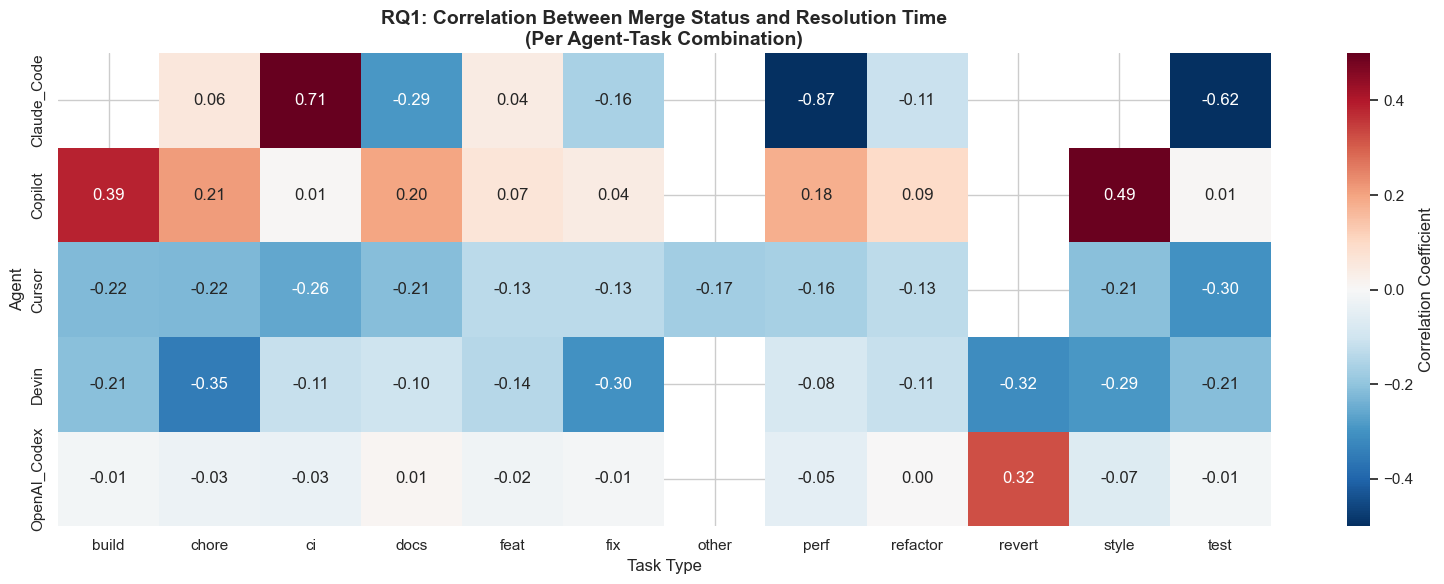

[INFO] Heatmap shows correlation coefficients. Red = positive, Blue = negative.


In [14]:
# correlation heatmap
pivot_corr = rq1_correlation_df.pivot(index='agent', columns='task_type', values='correlation_coefficient')

plt.figure(figsize=(16, 6))
sns.heatmap(pivot_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-0.5, vmax=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('RQ1: Correlation Between Merge Status and Resolution Time\n(Per Agent-Task Combination)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Task Type', fontsize=12)
plt.ylabel('Agent', fontsize=12)
plt.tight_layout()
plt.show()

print("[INFO] Heatmap shows correlation coefficients. Red = positive, Blue = negative.")

In [15]:
# Export Results to CSV Files
# Export detailed correlation results
correlation_output = Path("rq1_pr_level_correlation_results.csv")
rq1_correlation_df.to_csv(correlation_output, index=False)
print(f"[SAVED] PR-level correlation analysis results → {correlation_output}")

# Export summary by agent
agent_summary = rq1_correlation_df.groupby('agent').agg({
    'task_type': 'count',
    'correlation_coefficient': ['mean', 'median'],
    'abs_correlation': 'mean',
    'n_prs': 'sum'
}).round(3)
agent_summary.columns = ['n_task_types', 'mean_corr', 'median_corr', 'mean_abs_corr', 'total_prs']

agent_summary_output = Path("rq1_agent_summary.csv")
agent_summary.to_csv(agent_summary_output)
print(f"[SAVED] Agent summary statistics → {agent_summary_output}")

# Display summary
print("\n" + "="*80)
print("AGENT SUMMARY")
print("="*80)
display(agent_summary)

[SAVED] PR-level correlation analysis results → rq1_pr_level_correlation_results.csv
[SAVED] Agent summary statistics → rq1_agent_summary.csv

AGENT SUMMARY


,n_task_types,mean_corr,median_corr,mean_abs_corr,total_prs
agent,,,,,
Claude_Code,8,-0.155,-0.136,0.357,406
Copilot,10,0.169,0.138,0.169,4772
Cursor,11,-0.197,-0.211,0.197,1725
Devin,11,-0.204,-0.208,0.204,7583
OpenAI_Codex,11,0.009,-0.015,0.052,91399
